In [1]:
import glob
import argparse
import datetime
import os
from os.path import basename, dirname, join
import random

import numpy as np
import matplotlib.pyplot as plt

from data_generator import DataGeneratorFrom_npz_File

# %matplotlib inline
idir = '/tf/data/output'

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-rhqh62of because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
npz_files = sorted(glob.glob('/tf/data/output/*.npz'))

input_var_names = ['nersc_sar_primary', 'nersc_sar_secondary']
amsr2_var_names = [
    'btemp_6_9h',
    'btemp_6_9v',
    'btemp_7_3h',
    'btemp_7_3v',
    'btemp_10_7h',
    'btemp_10_7v',
    'btemp_18_7h',
    'btemp_18_7v',
    'btemp_23_8h',
    'btemp_23_8v',
    'btemp_36_5h',
    'btemp_36_5v',
    'btemp_89_0h',
    'btemp_89_0v',
 ]
output_var_name = 'ice_type'
distance_var_name = 'distance_border'

dims_input = np.load(npz_files[0])[input_var_names[0]].shape
dims_output = np.load(npz_files[0])[output_var_name].shape
dims_distance = np.load(npz_files[0])[distance_var_name].shape
dims_amsr2 = np.load(npz_files[0])[amsr2_var_names[0]].shape

params = {'dims_input':      (*dims_input, len(input_var_names)),
           'dims_output':     (*dims_output,),
           'dims_distance':   (*dims_distance,),
           'dims_amsr2':      (*dims_amsr2, len(amsr2_var_names)),
           'output_var_name': output_var_name,
           'distance_var_name': distance_var_name,
           'input_var_names': input_var_names,
           'amsr2_var_names': amsr2_var_names,
           'batch_size':      len(npz_files),
           'shuffle_on_epoch_end': False,
           }

In [3]:
training_generator = DataGeneratorFrom_npz_File(npz_files, **params)

list_output = training_generator[0][1]
list_dist = training_generator[0][2]
# print('output')
# print(list_output[:48])
# print('distance')
# print(list_dist)

concentration_scale = [0, 1, 2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 91, 92]
sod_scale = [0, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 93, 95, 96, 97, 98]
form_scale = [i for i in range (22)]+[99]

In [4]:
def creation_matrix_sod_form(list_output, list_distance, sod_scale, form_scale, dist_thresholds, visualization=False):    
    """
    This function creates a graph. 
    It represents the different possible combinations of SoD and ice shape.
    The value shown is the frequency of combinaison regardless of concentration. 
    In addition, if the distance to the zone is too small (below the threshold)
    then the data from the zone will not be taken into account.
    
    Parameters
    ----------
    list_output : list
        list of the output of preprocessing.
    list_distance : list
        list of the distance of preprocessing.
    sod_scale : list
        list that contains all the levels of Stade of development according to ASID-v2 manual.
    form_scale : list
        list that contains all the levels of form according to ASID-v2 manual.
    dist_thresholds : integer
        minimum border distance threshold.
    visualization : boolean
        if it makes graphiques.
    
    Returns
    -------
    result : list
        list of combinations and their frequencies.
    """
    sol = np.zeros((17,23))
    for output, dist in zip(list_output, list_dist) :
        if (dist > dist_thresholds) : # if the distance of the output is below the threshold, we don't keep
            for ice in range(3): # in a output there are 3 data for the 3 most present ice
                if output[1+ice*3]==(-9): 
                    continue
                if output[2+ice*3]==(-9): 
                    continue
                if output[3+ice*3]==(-9): 
                    continue
                index_sod = sod_scale.index(output[2+ice*3])
                index_form = form_scale.index(output[3+ice*3])
                sol[index_sod][index_form] += 1

    if visualization :
        plt.imshow(sol)
        plt.colorbar()
        plt.title('Frequency of combinations regardless of concentration')
        plt.xlabel('Form')
        plt.ylabel('Stage of Development')
        plt.show()
    return sol

In [5]:
def creation_matrix_sod_form_con(list_output, list_distance, concentration_scale, sod_scale, form_scale, dist_thresholds, visualization=False):
    """
    This function creates a graph for each categorie of ice concentration. 
    It represents the different possible combinations of SoD and ice shape.
    The value shown is the number of the presence of the 3 most present ice. 
    In addition, if the distance to the zone is too small (below the threshold)
    then the data from the zone will not be taken into account.
    
    Parameters
    ----------
    list_output : list
        list of the output of preprocessing.
    list_distance : list
        list of the distance of preprocessing.
    concentration_scale : list
        list that contains all the levels of concentration according to ASID-v2 manual.
    sod_scale : list
        list that contains all the levels of Stade of development according to ASID-v2 manual.
    form_scale : list
        list that contains all the levels of form according to ASID-v2 manual.
    dist_thresholds : integer
        minimum border distance threshold.
    visualization : boolean
        if it makes graphiques.
    
    Returns
    -------
    result : list
        list of combinations and their frequencies for each levels of concentration.
    """
    
    result = []
    list_all_output = []
    #this part allows to obtain all the data vectors and
    #to sort the vectors whose distance is lower than the threshold
    for output, dist in zip(list_output, list_dist) :
        if (dist > dist_thresholds) :
            for ice in range(3):
                if output[1+ice*3]==(-9):
                    continue
                if output[2+ice*3]==(-9): 
                    continue
                if output[3+ice*3]==(-9): 
                    continue
                list_all_output.append(output[1+ice*3:4+ice*3])

    for c in concentration_scale : #loop for each categorie of ice concentration
        sol = np.zeros((17,23))
        for one_output in list_all_output :            
            if (c==one_output[0]):
                index_sod = sod_scale.index(one_output[1])
                index_form = form_scale.index(one_output[2])
                sol[index_sod][index_form] += 1
        result.append(sol)
        if visualization :
            plt.imshow(sol)
            plt.colorbar()
            plt.title('Frequency of combinations : concentration of '+str(c)+' %')
            plt.xlabel('Form')
            plt.ylabel('Stage of Development')
            plt.show()
    return result

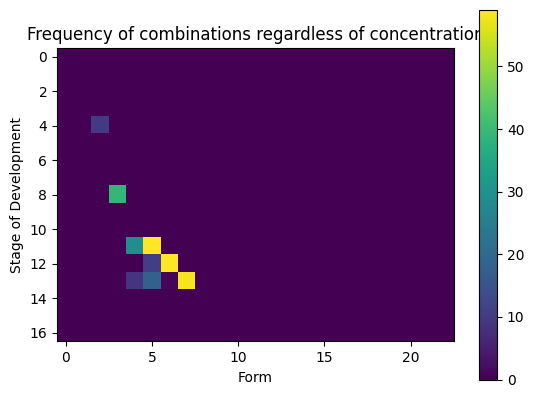

In [6]:
array = creation_matrix_sod_form(list_output, list_dist, sod_scale, form_scale, 250, visualization=True)

In [7]:
arrays = creation_matrix_sod_form_con(list_output, list_dist, concentration_scale, sod_scale, form_scale, 250, visualization=False)

In [8]:
def histo_sod_form(list_sod_form, sod_scale, form_scale):
    """
    Create a histogramme of frequency of combinations regardless of concentration
    
    Parameters
    ----------
    arraylist_sod_form : list
        list of combinations and their frequencies.
    sod_scale : list
        list that contains all the levels of Stade of development according to ASID-v2 manual.
    form_scale : list
        list that contains all the levels of form according to ASID-v2 manual.
    
    Returns
    -------
    result : list
        list of combinations and their frequencies not null.
    """
    solution=[]
    x_label=[]
    for stage, stage_label in zip (list_sod_form, sod_scale) :
        for form, form_label in zip (stage, form_scale) :
            if (form!=0):
                combinaison = str(stage_label)+'_'+str(form_label)
                solution.append([combinaison, int(form)])
                x_label+=[combinaison]*int(form)
    plt.hist(x_label)
    plt.title('Frequency of combinations regardless of concentration')
    plt.xlabel('Combinations (sod_form)')
    plt.ylabel('Frequency')
    plt.show()
    return solution

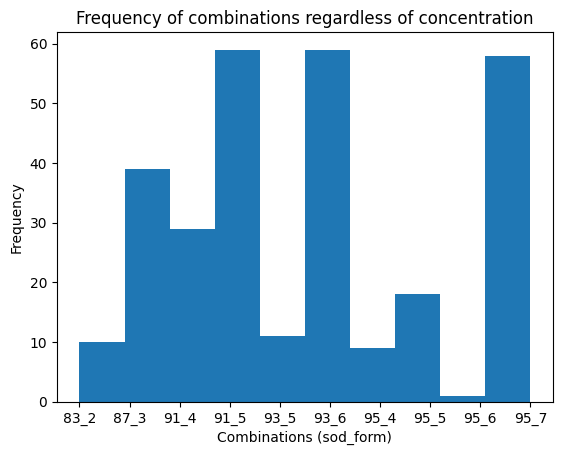

[['83_2', 10], ['87_3', 39], ['91_4', 29], ['91_5', 59], ['93_5', 11], ['93_6', 59], ['95_4', 9], ['95_5', 18], ['95_6', 1], ['95_7', 58]]


In [9]:
without_c = histo_sod_form(array, sod_scale, form_scale)
print(without_c)

In [10]:
def histo_sod_form_con(list_sod_form_con, concentration_scale, sod_scale, form_scale):
    """
    Create a histogramme of frequency of combinations depending on concentration
    
    Parameters
    ----------
    arraylist_sod_form : list
        list of combinations and their frequencies.
    concentration_scale : list
        list that contains all the levels of concentration according to ASID-v2 manual.
    sod_scale : list
        list that contains all the levels of Stade of development according to ASID-v2 manual.
    form_scale : list
        list that contains all the levels of form according to ASID-v2 manual.
    
    Returns
    -------
    result : list
        list of combinations and their frequencies not null for each levels of concentration.
    """
    solution=[]
    
    for list_sod_form, c in zip (list_sod_form_con, concentration_scale) : #loop for each categorie of ice concentration 
        sol=[]
        x_label=[]
        if (np.amax(list_sod_form)==np.amin(list_sod_form)) :
            continue
        for stage, stage_label in zip (list_sod_form, sod_scale) :
            for form, form_label in zip (stage, form_scale) :
                if (form!=0):
                    combinaison = str(stage_label)+'_'+str(form_label)
                    sol.append([combinaison, int(form)])
                    x_label+=[combinaison]*int(form)
        plt.hist(x_label)
        plt.title('Frequency of combinations : concentration of '+str(c)+' %')
        plt.xlabel('Combinations (sod_form)')
        plt.ylabel('Frequency')
        plt.show()
        solution.append([str(c)+' %',sol])
    return solution

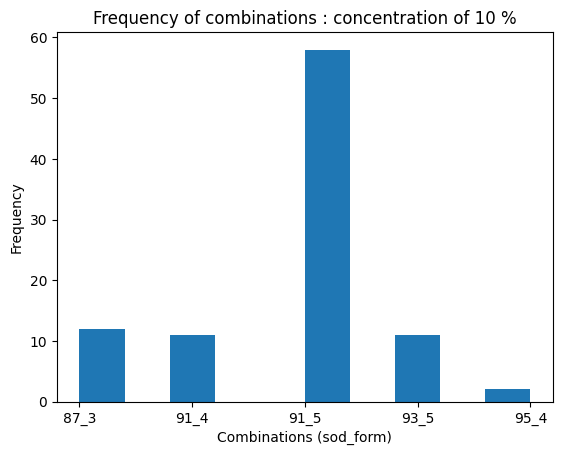

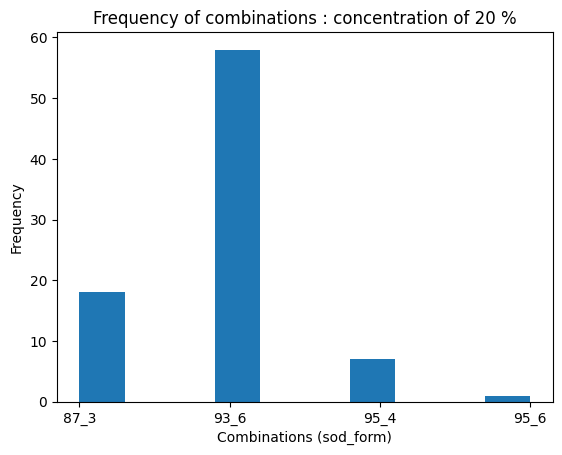

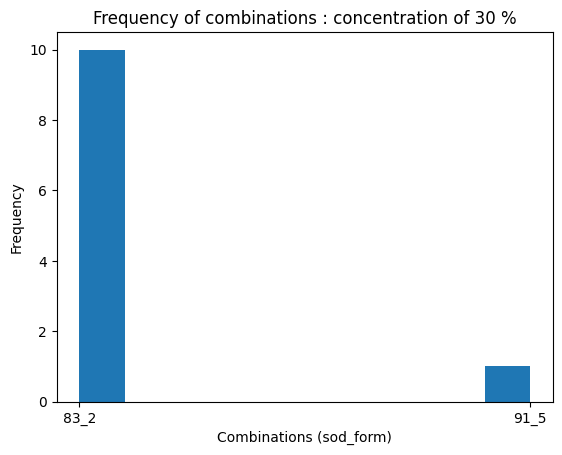

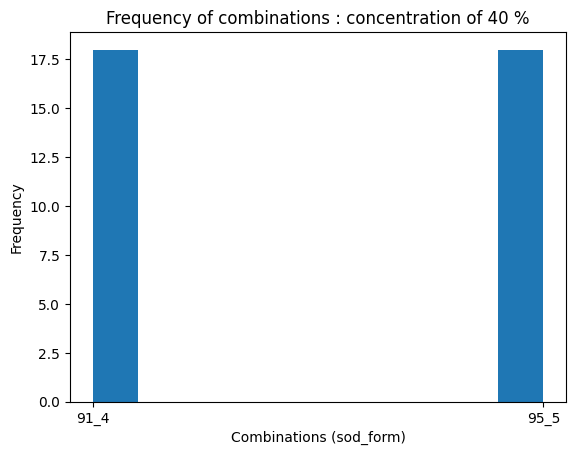

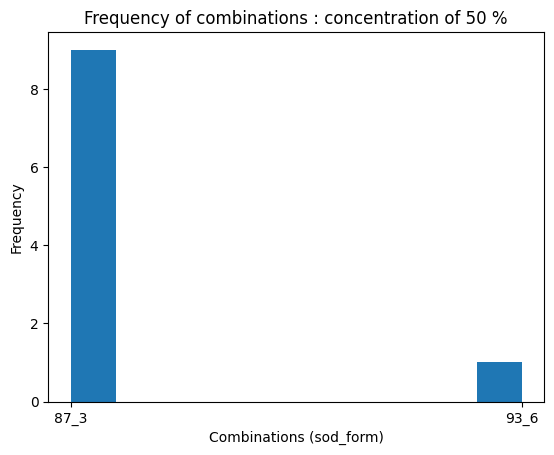

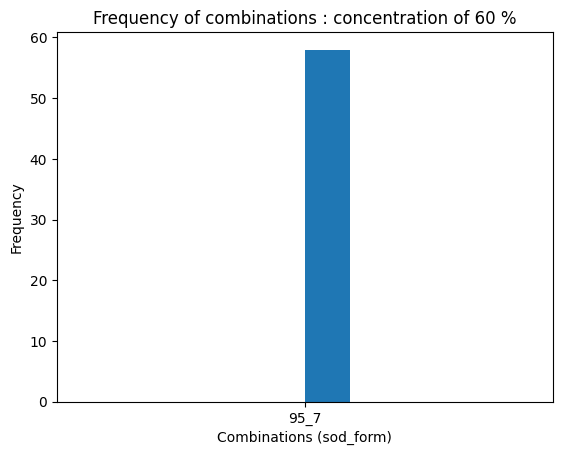

[['10 %', [['87_3', 12], ['91_4', 11], ['91_5', 58], ['93_5', 11], ['95_4', 2]]], ['20 %', [['87_3', 18], ['93_6', 58], ['95_4', 7], ['95_6', 1]]], ['30 %', [['83_2', 10], ['91_5', 1]]], ['40 %', [['91_4', 18], ['95_5', 18]]], ['50 %', [['87_3', 9], ['93_6', 1]]], ['60 %', [['95_7', 58]]]]


In [11]:
print(histo_sod_form_con(arrays, concentration_scale, sod_scale, form_scale))